# TensorBoard Embedding Projector for Visualization

This notebook introduces the **TensorBoard Embedding Projector** tool for visualizing high-dimensional vector spaces in 2D/3D.

First, we'll generate observation/state samples by playing games using the pretrained DQN. Observations will stored with probability 0.5% to minimize correlation and sample from a wide variety of episodes.

In [1]:
import gym
import random
import numpy as np
from dqn import Agent, Util
import tensorflow as tf

Using TensorFlow backend.


In [2]:
# Create our gym environment
env = gym.make('Breakout-v0')
# And pass it to the Agent to initialize the pretrained network
agent = Agent(env, mode='test', load_network=True, epsilon=0.01)

[2017-05-31 17:11:20,374] Making new env: Breakout-v0


Environment <TimeLimit<AtariEnv<Breakout-v0>>> has 4 actions
INFO:tensorflow:Restoring parameters from saved_networks/Breakout-v0-44400000


[2017-05-31 17:11:20,921] Restoring parameters from saved_networks/Breakout-v0-44400000


Successfully loaded: saved_networks/Breakout-v0-44400000


In [3]:
NUM_SAMPLES  = 48*48    # Take 2304 total samples
SAMPLES_PROB = 0.01     # Store a sample 1% of the time
NO_OP_STEPS  = 30       # Max # of steps to do nothing, helps randomize init condition
STATE_LENGTH = 4        # # of previous frames to stack as our "state"

obvs = []               # Store observation RGB frames
states = []             # Store 84x84x4 
rewards = []            # Track the total reward for each episode
ts = []                 # Store the episode timestep for each sample

avg_reward = 0
ep_count = 0

# Keep playing episodes until we've collected NUM_SAMPLES
while len(obvs) < NUM_SAMPLES:
    ep_count += 1
    total_reward = 0
    terminal = False
    
    # Initialize environment
    observation = env.reset()
    # For a random # of steps do nothing, helps to randomize init state
    for _ in range(random.randint(1, NO_OP_STEPS)):
        observation, _, _, _ = env.step(0)  # Do nothing

    # Preprocess 210x160x3 RGB observation to 84x84x1 
    state = Util.preprocess(observation)
    # Create initial state by repeating the first frame 4x to create 84x84x4 input
    state = np.stack([state]*STATE_LENGTH, axis=2).reshape((84,84,4))

    t = 0  # Timestep counter
    
    while not terminal:   
        # With SAMPLES_PROB probability, store the last observation (210x160x3), state (84x84x4), and ep timestep
        if random.random() < SAMPLES_PROB:
            obvs.append(observation)
            states.append(state)
            ts.append(t)
        
        # Feed the state into the model to get an action (determined by max Q-value)
        action = agent.get_action(state)
        
        # Take the action and get new observation, reward, and if we are done with the episode
        observation, reward, terminal, _ = env.step(action)
        
        # Convert new observation to 84x84x1
        next_state = Util.preprocess(observation)
        # Pop the oldest frame and append the processed new frame
        next_state = np.append(state, next_state, axis=2)[:,:,1:]

        # Update total reward for this episode
        total_reward += reward

        # next_state will become the state input for the next timestep
        state = next_state
        
        # Inc timestep counter
        t += 1
        
    avg_reward += total_reward
    print ("Finished episode: {} with reward {} sample count: {}".format(ep_count, total_reward, len(obvs)))
    
    rewards.append(total_reward)
    
# Clip observation/state arrays to # of samples we want
obvs = obvs[:NUM_SAMPLES]
states = states[:NUM_SAMPLES]
    
avg_reward /= ep_count
print ("Collected {} obvs/states with avg reward {}".format(len(obvs), avg_reward))

Finished episode: 1 with reward 136.0 sample count: 25
Finished episode: 2 with reward 146.0 sample count: 43
Finished episode: 3 with reward 227.0 sample count: 78
Finished episode: 4 with reward 55.0 sample count: 90
Finished episode: 5 with reward 105.0 sample count: 112
Finished episode: 6 with reward 160.0 sample count: 126
Finished episode: 7 with reward 103.0 sample count: 137
Finished episode: 8 with reward 96.0 sample count: 156
Finished episode: 9 with reward 155.0 sample count: 174
Finished episode: 10 with reward 196.0 sample count: 217
Finished episode: 11 with reward 129.0 sample count: 239
Finished episode: 12 with reward 110.0 sample count: 268
Finished episode: 13 with reward 92.0 sample count: 284
Finished episode: 14 with reward 166.0 sample count: 313
Finished episode: 15 with reward 176.0 sample count: 336
Finished episode: 16 with reward 90.0 sample count: 355
Finished episode: 17 with reward 74.0 sample count: 376
Finished episode: 18 with reward 124.0 sample cou

Great, now we have some data that we can transform to gain some insights into what the Q-network is doing.

But first, let's see how the episode rewards are distributed:

(array([  4.,   2.,   3.,   6.,   2.,   4.,   8.,   7.,   5.,   5.,   3.,
         10.,   4.,   5.,   2.,   7.,   2.,   3.,   1.,   3.,   4.,   3.,
          3.,   1.,   2.,   0.,   0.,   2.,   1.,   0.,   0.,   0.,   0.,
          0.,   2.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   2.,   0.,   1.]),
 array([  44.  ,   49.32,   54.64,   59.96,   65.28,   70.6 ,   75.92,
          81.24,   86.56,   91.88,   97.2 ,  102.52,  107.84,  113.16,
         118.48,  123.8 ,  129.12,  134.44,  139.76,  145.08,  150.4 ,
         155.72,  161.04,  166.36,  171.68,  177.  ,  182.32,  187.64,
         192.96,  198.28,  203.6 ,  208.92,  214.24,  219.56,  224.88,
         230.2 ,  235.52,  240.84,  246.16,  251.48,  256.8 ,  262.12,
         267.44,  272.76,  278.08,  283.4 ,  288.72,  294.04,  299.36,
         304.68,  310.  ]),
 <a list of 50 Patch objects>)

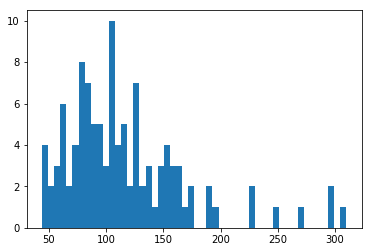

In [4]:
# Magic to display images inline in the notebook
%matplotlib inline    
import matplotlib.pyplot as plt

plt.hist(np.array(rewards), bins=50)

Now let's take a look at what these observations/states look like:

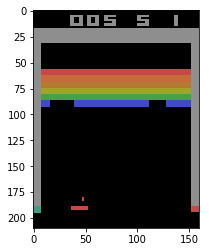

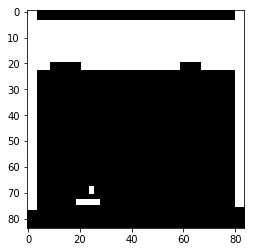

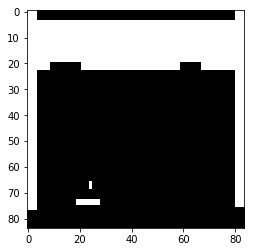

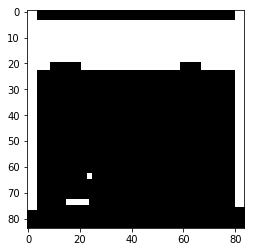

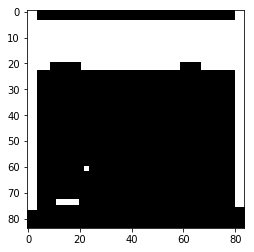

In [5]:
# Choose a random sample
rand_idx = random.randint(0, len(obvs))

# Display the RGB observation image
obv = obvs[rand_idx]
plt.figure()
plt.imshow(obv)

# Display each frame in the 84x84x4 state stack
state = states[rand_idx]
for i in reversed(range(STATE_LENGTH)):
    plt.figure()
    plt.imshow(state[..., i], cmap="gray")

Unfortunately, the RGB observation images don't give us any information about the trajectory of the ball and in some cases don't even show the ball (due to flickering in the original game). Let's fix that.

Each observation corresponds to a processed 84x84x4 state array, which contains a binary black/white version of the observation frame, as well as the 3 preceding frames. If we drop the oldest frame, we can treat the resulting 84x84x3 as an RGB image stack that shows how the state changes over 3 timesteps. We'll use this in place of the observation when visualizing with TensorBoard.

When the 3 timesteps are interpreted as an RGB image, the red channel corresponds to the observation at timestep t-2, green to t-1, and blue to the current timestep. Thus, when visualizing this array as an image, the blue pixels correspond to the current observation, and green/red display the previous states. This effectively plots the trajectory and gives some indication of the velocity of the ball & paddle.

(2304, 84, 84, 3)


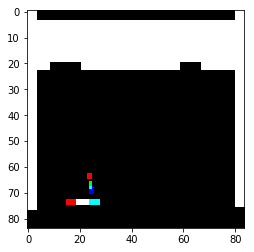

In [6]:
def state_to_rgb(state):
    # Extract the three most recent frames and multiply by 255 to convert binary 1's -> 255
    return state[...,1:]*255

stacks = np.array([state_to_rgb(state) for state in states])
print(stacks.shape)

plt.imshow(stacks[rand_idx])

Next, we're going to run each 84x84x4 state array through the Q network to obtain Q-values for each possible action. But first, let's take a look at the Q network architecture:

In [7]:
sample_obvs = stacks
sample_states = np.array(states)
sample_states.shape

(2304, 84, 84, 4)

In [9]:
sample_qs = agent.q_values.eval(feed_dict={agent.s: sample_states})

sample_qs_max = np.max(sample_qs, axis=1)
# sample_qs_max = ( sample_qs_max - sample_qs_max.mean() ) / sample_qs_max.std()

print ("Min Q",sample_qs_max.min())
print ("Max Q",sample_qs_max.max())

# Normalize
# sample_qs_max_norm = (sample_qs_max - sample_qs_max.min()) / (sample_qs_max.max() - sample_qs_max.min()) * 100

print(sample_qs.shape)
print(sample_qs_max.shape)

Min Q 0.689732
Max Q 12.7718
(2304, 4)
(2304,)


In [10]:
# Action space corresponds to ['NOOP', 'FIRE', 'RIGHT', 'LEFT']
sample_actions = np.argmax(sample_qs, axis=1)
action_map = np.vectorize({0:'NOOP', 1:'FIRE', 2:'RIGHT', 3:'LEFT'}.get)
sample_actions_map = action_map(sample_actions)

In [11]:
sample_fc_vecs = agent.q_network.get_layer('dense_1').output \
                       .eval(feed_dict={agent.q_network.layers[0].input: sample_states})
sample_fc_vecs.shape

(2304, 512)

(8064, 6144, 3)


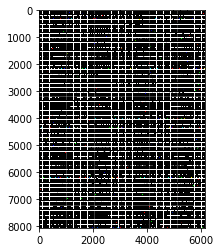

In [12]:
import scipy
from PIL import Image

def TileImage(imgs, picturesPerRow=48, picturesPerColumn=48):
    # Resize to 80%
    resized = np.array([scipy.misc.imresize(img, (168, 128)) for img in imgs])
    # Tiling Loop (The conditionals are not necessary anymore)
    tiled = []
    for i in range(0,picturesPerColumn*picturesPerRow,picturesPerRow):
        tiled.append(np.hstack(resized[i:i+picturesPerRow,:,:]))
    return np.vstack(tiled)

sprite = TileImage(sample_obvs)
print (sprite.shape)

im = Image.fromarray(sprite)
im.save('./summary/sprite.png')

plt.imshow(sprite)

## Write metadata

In [30]:
import os
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.tensorboard.plugins import projector

LOG_DIR = './summary/'
metadata = os.path.join(LOG_DIR, 'metadata.tsv')

with open(metadata,'w') as f:
    f.write('q-max\taction\ttimestep\n')
    for i,q in enumerate(sample_qs_max):
        f.write("{:.3f}\t{}\t{}\n".format(q, sample_actions_map[i], ts[i]))

In [ ]:
## Run embeddings op 

In [31]:
embeddings = tf.Variable(sample_fc_vecs, name='state_embeddings')

with tf.Session() as sess:
    saver = tf.train.Saver([embeddings])

    sess.run(embeddings.initializer)  # Load state embeddings into the var
    saver.save(sess, os.path.join(LOG_DIR, 'images.ckpt'))

    config = projector.ProjectorConfig()
    # One can add multiple embeddings.
    embedding = config.embeddings.add()
    embedding.tensor_name = embeddings.name
    # Link this tensor to its metadata file (e.g. labels).
    embedding.metadata_path = metadata
    # Point to sprite image
    embedding.sprite.image_path = './summary/sprite.png'
    # Specify the width and height of a single thumbnail.
    embedding.sprite.single_image_dim.extend([128, 168])
    # Saves a config file that TensorBoard will read during startup.
    projector.visualize_embeddings(tf.summary.FileWriter(LOG_DIR), config)

### Now open TensorBoard and navigate to http://localhost:6006/

In [ ]:
!tensorboard --logdir ./summary --port 6006

Starting TensorBoard b'47' at http://0.0.0.0:6006
(Press CTRL+C to quit)


### Go to the Embeddings tab and play with different color maps, labelings, and t-SNE

# Resources

* Official TB Embedding Projector docs https://www.tensorflow.org/get_started/embedding_viz
* http://www.pinchofintelligence.com/simple-introduction-to-tensorboard-embedding-visualisation/
* http://stackoverflow.com/questions/40849116/how-to-use-tensorboard-embedding-projector
* https://github.com/tensorflow/tensorflow/issues/6322